In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('..')

This notebook is a guide for the neural networks based models of the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [MLP](#first-subbullet)
* [GRIN](#second-bullet)

All neural networks based models are trained following the same procedure implemented by the Filler. 

### MLP training <a class="anchor" id="first-bullet"></a>

In [2]:
from data_provider.data_provider import DataProvider
from models.linear_MLP import linear_MLP
from trainer.Filler import Filler

from types import SimpleNamespace

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 10
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-5
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(linear_MLP, model_kwargs, filler_kwargs)

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [4]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader)
filler.save_model('../trained_models/linear_MLP.pt')

start training
Epoch 1/100, Train Loss: 22.49910144, Test Loss: 30.26517887, time: 0.52s
Epoch 2/100, Train Loss: 18.91581992, Test Loss: 25.98423891, time: 0.86s
Epoch 3/100, Train Loss: 16.18109312, Test Loss: 22.53253069, time: 1.24s
Epoch 4/100, Train Loss: 14.01226229, Test Loss: 19.72550373, time: 1.59s
Epoch 5/100, Train Loss: 12.26700183, Test Loss: 17.41653280, time: 1.93s
Epoch 6/100, Train Loss: 10.84719437, Test Loss: 15.50162897, time: 2.27s
Epoch 7/100, Train Loss: 9.68265609, Test Loss: 13.90398353, time: 2.60s
Epoch 8/100, Train Loss: 8.72117166, Test Loss: 12.56442048, time: 2.92s
Epoch 9/100, Train Loss: 7.92287648, Test Loss: 11.43646841, time: 3.26s
Epoch 10/100, Train Loss: 7.25679945, Test Loss: 10.48323793, time: 3.60s
Epoch 11/100, Train Loss: 6.69857221, Test Loss: 9.67511365, time: 3.95s
Epoch 12/100, Train Loss: 6.22882815, Test Loss: 8.98809169, time: 4.28s
Epoch 13/100, Train Loss: 5.83205060, Test Loss: 8.40257179, time: 4.62s
Epoch 14/100, Train Loss: 5.4

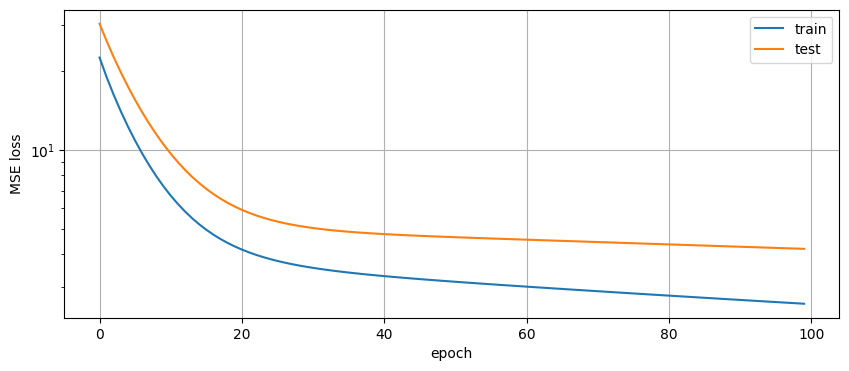

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
# plt.ylim(0.01, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()

### GRIN <a class="anchor" id="second-bullet"></a>

In [6]:
from data_provider.data_provider import DataProvider
from models.GRIN import GRINet
from trainer.Filler import Filler

from types import SimpleNamespace

device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


device:  cpu


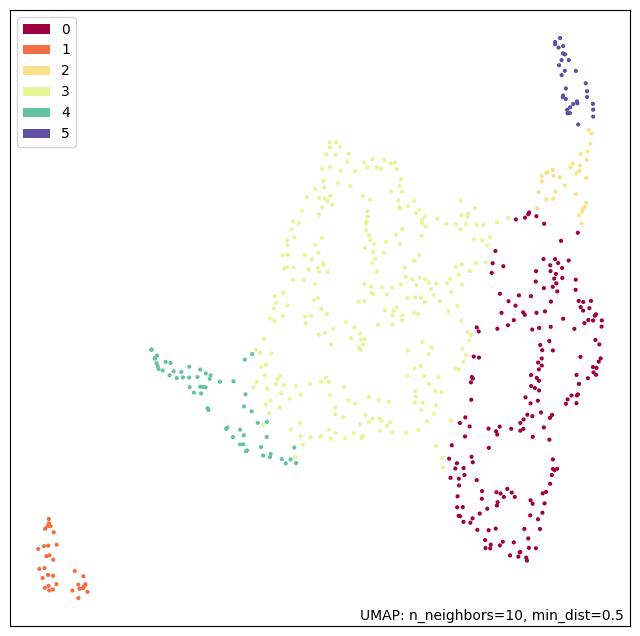

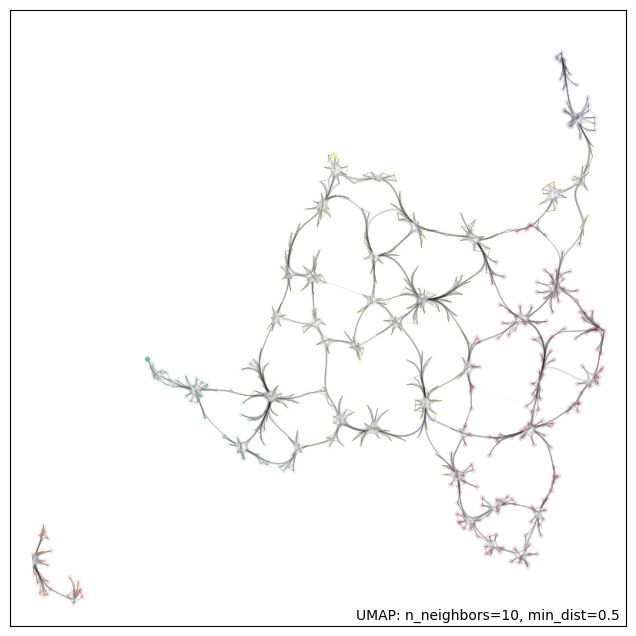

In [7]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.scaler = None
data_kwargs.batch_size = 100
data_kwargs.window = 24*2
data_kwargs.horizon = 0
data_kwargs.mask_proba = 0.5
data_kwargs.mask_length = 24*7*1

data_provider = DataProvider(data_kwargs)
adjacency_matrix = data_provider.data.umap_adjacency(threshold=0.99, verbose=True)
ordered_indices = scipy.sparse.csgraph.reverse_cuthill_mckee(graph=scipy.sparse.csr_matrix(adjacency_matrix), symmetric_mode=True)
adjacency_matrix = torch.tensor(adjacency_matrix[ordered_indices, :][:, ordered_indices]).to('cuda:0' if torch.cuda.is_available() else 'cpu')
#adjacency_matrix = torch.FloatTensor(data_provider.data.correlation_adjacency())
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(adj=adjacency_matrix, d_in=1)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-5
filler_kwargs.epochs = 10
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(GRINet, model_kwargs, filler_kwargs)

In [8]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader)

start training


: 

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.ylim(0, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()